# Comparison of runtime logs for stochastic estimators

This notebook is meant to examine **which of the stochastic estimators performs the best**. All models are trained **entirely from scratch** (i.e. no pretraining).

The experimental procedure will be the same to that we saw in the runtime comparison of deterministic estimator settings:

> Runtime logs are meant to study a model's **convergence**, i.e. *how many epochs does it take for a model to converge?*, *does it experience heavy oscillations during training?*, etc. They **aren't** meant to examine the model's generalization. There are two types of runtime logs:
> 
> - **epoch** logs are the ones that are recorded **once per epoch** (usually at the end of the epoch), e.g. validation metrics.
> - **batch** logs are the ones that are recorded **once per batch** (i.e. once per model update), e.g. the model's loss.
> 
> While it is possible to examine the logs in other ways, the scope of this study involves examining the **least** amount of information that the models require to **adequately** classify. Thus we'll follow the following procedure:
> 
> 1. For each model that we want to examine, first we'll check its **validation accuracy**. Only models with sufficiently high validation accuracy, comared to the baseline, will be examined further.
> 2. They we'll check the model's **percentage of pixels hidden**. As we said we are interested in finding the least amount of information that the models require, so we'll keep the models that hide large percentage of pixels.
> 3. After filtering the models by these two conditions, we'll examine things such as the convergence speed and the stability of the model.

Like previously, each model is trained **10 times** independently, to properly measure the **variance** of the training procedure.

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('once')

from utils.plotting import *

%matplotlib inline

/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/thanos/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])


## 1. Epoch logs

Well first read the epoch logs to find the models that performed adequately on the validation set.

### Load the baseline 

This baseline is the validation accuracy achieved by the same architecture that is used for the **seeker** on the test set, without hiding any pixels.

In [3]:
baseline_loc = '../results/cifar10/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

Baseline accuracy: 65.37%


### a) ST1

This is the **first variant of the straight-through estimator**, which completely ignores both the sigmoid and threshold functions (i.e. the derivative is the same as an identity function):

$$
\hat g_{st}^{(1)}(W) = \frac{\partial h(W)}{\partial W} = x
$$

Let's plot the runtime validation accuracy of all 10 ST1 models.

W0305 12:19:18.820589 140578890237696 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Text(0.5, 1.0, 'Straight-Through v1')

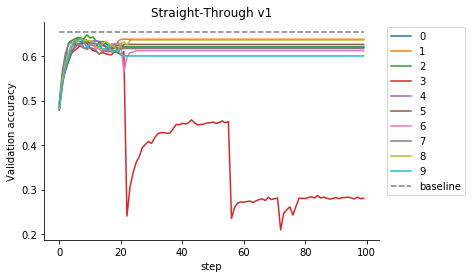

In [4]:
experiment_dir = '../logs/cifar10/hns/stochastic/st1/full_training_10/'
st1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(st1_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Straight-Through v1')

Initially we observe that there are **no collapses** and that only one model scores a sub-par classification accuracy!

### b) ST2

This is the **second variant of the straight-through estimator**, which completely ignores and threshold function but not the sigmoid (i.e. the derivative is the same as a sigmoid):

$$
\hat g_{st}^{(2)}(W) = \frac{\partial \sigma(h(W))}{\partial W} = \sigma(h) \cdot (1 - \sigma(h)) \cdot x
$$

Text(0.5, 1.0, 'Straight-Through v2')

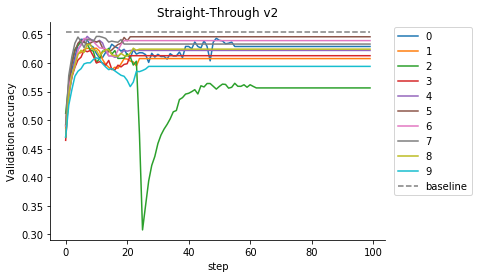

In [5]:
experiment_dir = '../logs/cifar10/hns/stochastic/st2/full_training_10/'
st2_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(st2_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Straight-Through v2')

Even though one model collapsed for a bit during training, the stochasticity of the loss function **allowed it to recover**. All in all, **no models collepsed**, while all scoring a near-baseline performance.

### c) SA

This family describes the **slope-annealing estimators**. These are the similar to ST2, but the slope of the sigmoid **increases over time**, to help the sigmoid simulate a step function. The rate of which the slope increased was also examined to identify the optimal

A rate of 0.5 means that at the end of the epoch the slope of the sigmoid is 50% steeper than it was in the beginning.

#### Rate=0.1

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.1')

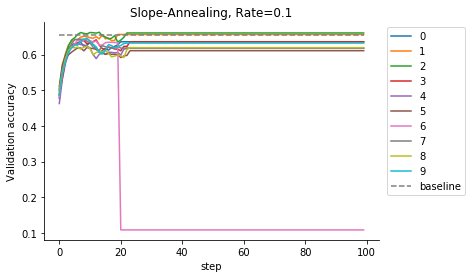

In [6]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.1/full_training_10/'
sa_01_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(sa_01_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Slope-Annealing, Rate=0.1')

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.1')

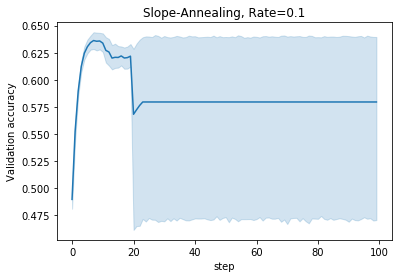

In [7]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_01_epoch_logs))
plt.title('Slope-Annealing, Rate=0.1')

#### Rate=0.5

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.5')

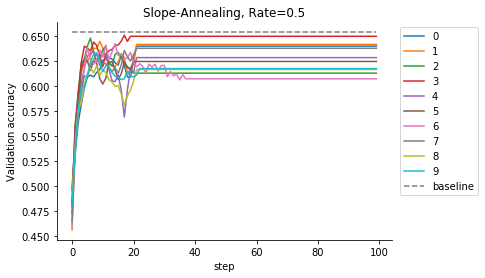

In [8]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.5/full_training_10/'
sa_05_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(sa_05_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Slope-Annealing, Rate=0.5')

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.5')

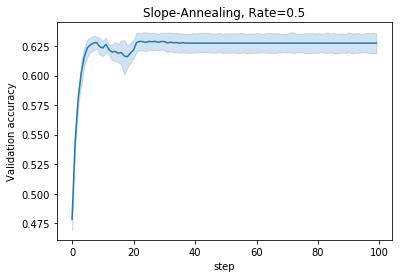

In [9]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_05_epoch_logs))
plt.title('Slope-Annealing, Rate=0.5')

#### Rate=1

Text(0.5, 1.0, 'Slope-Annealing, Rate=1')

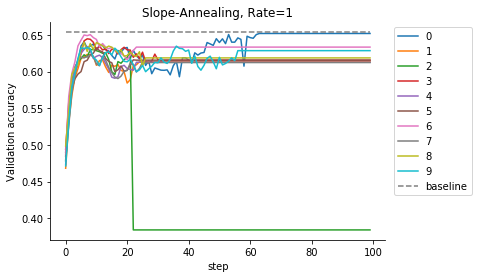

In [10]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_1.0/full_training_10/'
sa_1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(sa_1_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Slope-Annealing, Rate=1')

Text(0.5, 1.0, 'Slope-Annealing, Rate=1')

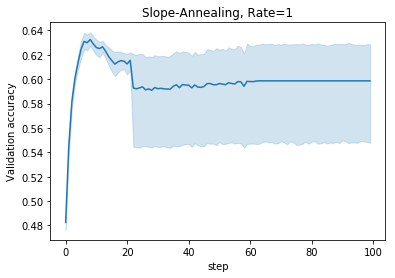

In [11]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_1_epoch_logs))
plt.title('Slope-Annealing, Rate=1')

#### Rate=10

Text(0.5, 1.0, 'Slope-Annealing, Rate=10')

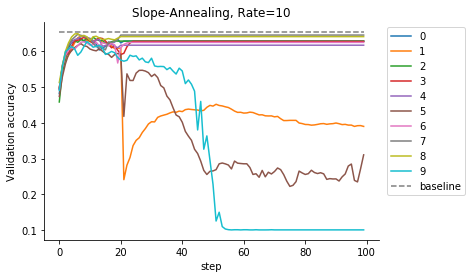

In [12]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_10.1/full_training_10/'
sa_10_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(sa_10_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Slope-Annealing, Rate=10')

Text(0.5, 1.0, 'Slope-Annealing, Rate=10')

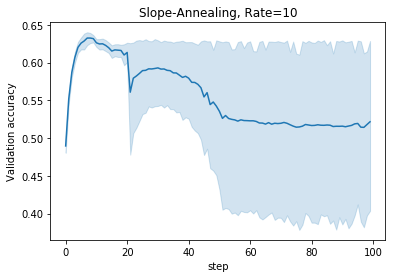

In [13]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_10_epoch_logs))
plt.title('Slope-Annealing, Rate=10')

#### Rate=100

Text(0.5, 1.0, 'Slope-Annealing, Rate=100')

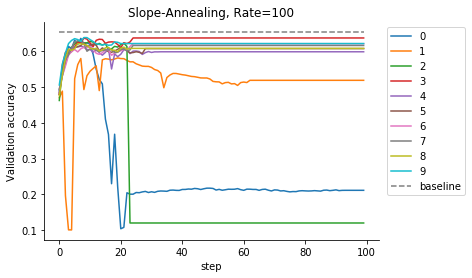

In [14]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_100.1/full_training_10/'
sa_100_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(sa_100_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('Slope-Annealing, Rate=100')

Text(0.5, 1.0, 'Slope-Annealing, Rate=100')

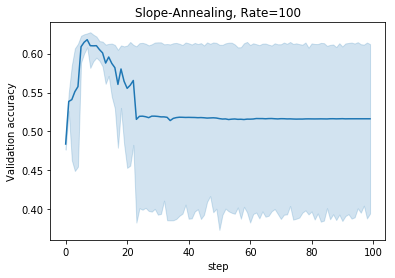

In [15]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_100_epoch_logs))
plt.title('Slope-Annealing, Rate=100')

The slope annealing estimator is made to behave similar to a deterministic estimator during later epochs, especially for large rates. This is why we witnessed a few collapses and sub-optimal performances. 

### d) REINFORCE

$$
\hat g_{rf} = (J - \tilde J) \cdot (H - \sigma(h))
$$

where

$$
\tilde J = \frac{\mathbb{E}[(H - sigm(h))^2 \cdot J]}{\mathbb{E}[(H - sigm(h))^2]}
$$

Text(0.5, 1.0, 'REINFORCE')

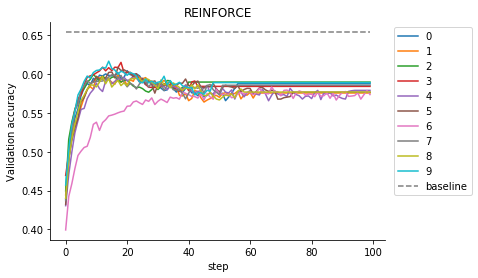

In [16]:
experiment_dir = '../logs/cifar10/hns/stochastic/reinforce/full_training_10/'
reinforce_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
plot_all_logs(reinforce_epoch_logs, 'Validation accuracy', baseline=baseline)
plt.title('REINFORCE')

## 2. Batch logs

Like in the deterministic case, we'll filter out models that score under $90\%$ of the baseline ($\approx 59\%$ validaition accuracy).

An additional option is available for undersampling the logs, if they take too long to plot (see `utils.plotting.load_and_process_batch_logs_from_dir`).

### a) ST1

Text(0.5, 1.0, 'Straight-Through v1')

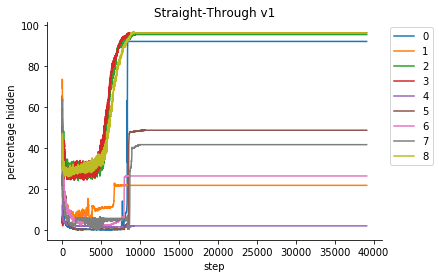

In [17]:
experiment_dir = '../logs/cifar10/hns/stochastic/st1/full_training_10/'
st1_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
st1_batch_logs_f = filter_logs_on_val_acc(st1_epoch_logs, st1_batch_logs, baseline)
plot_all_logs(st1_batch_logs_f, 'percentage hidden')
plt.title('Straight-Through v1')

Here there were a few collapses, or sub-par performances...

### b) ST2

Text(0.5, 1.0, 'Straight-Through v2')

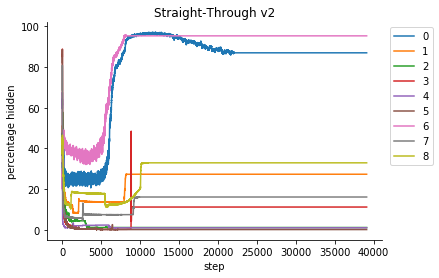

In [18]:
experiment_dir = '../logs/cifar10/hns/stochastic/st2/full_training_10/'
st2_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
st2_batch_logs_f = filter_logs_on_val_acc(st2_epoch_logs, st2_batch_logs, baseline)
plot_all_logs(st2_batch_logs_f, 'percentage hidden')
plt.title('Straight-Through v2')

This estimator allowed the models to converge easily to sub-par masking solutions. Only one managed peak masking percentage.

### c) SA

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.1')

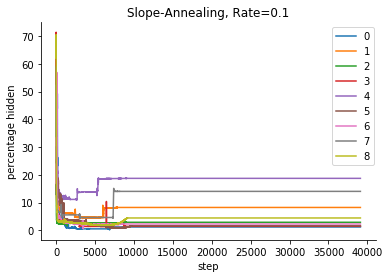

In [19]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.1/full_training_10/'
sa_01_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
sa_01_batch_logs_f = filter_logs_on_val_acc(sa_01_epoch_logs, sa_01_batch_logs, baseline)
plot_all_logs(sa_01_batch_logs_f, 'percentage hidden')
plt.title('Slope-Annealing, Rate=0.1')

Text(0.5, 1.0, 'Slope-Annealing, Rate=0.5')

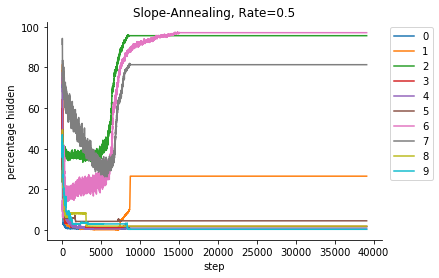

In [20]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.5/full_training_10/'
sa_05_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
sa_05_batch_logs_f = filter_logs_on_val_acc(sa_05_epoch_logs, sa_05_batch_logs, baseline)
plot_all_logs(sa_05_batch_logs_f, 'percentage hidden')
plt.title('Slope-Annealing, Rate=0.5')

Text(0.5, 1.0, 'Slope-Annealing, Rate=1')

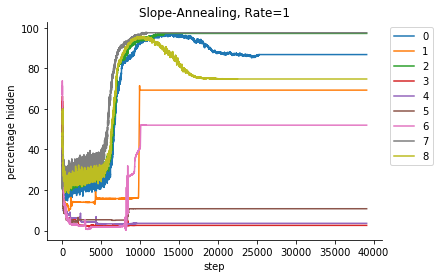

In [21]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_1.0/full_training_10/'
sa_1_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
sa_1_batch_logs_f = filter_logs_on_val_acc(sa_1_epoch_logs, sa_1_batch_logs, baseline)
plot_all_logs(sa_1_batch_logs_f, 'percentage hidden')
plt.title('Slope-Annealing, Rate=1')

Text(0.5, 1.0, 'Slope-Annealing, Rate=10')

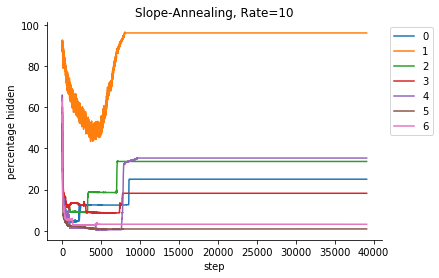

In [22]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_10.1/full_training_10/'
sa_10_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
sa_10_batch_logs_f = filter_logs_on_val_acc(sa_10_epoch_logs, sa_10_batch_logs, baseline)
plot_all_logs(sa_10_batch_logs_f, 'percentage hidden')
plt.title('Slope-Annealing, Rate=10')

Text(0.5, 1.0, 'Slope-Annealing, Rate=100')

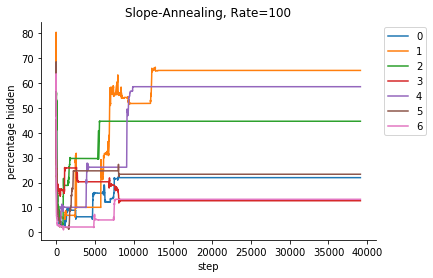

In [23]:
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_100.1/full_training_10/'
sa_100_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
sa_100_batch_logs_f = filter_logs_on_val_acc(sa_100_epoch_logs, sa_100_batch_logs, baseline)
plot_all_logs(sa_100_batch_logs_f, 'percentage hidden')
plt.title('Slope-Annealing, Rate=100')

During the higher rates, a lot of sub-optimal masking solutions are observed. For the lower rates, a lot of models actually managed to converge to high masking percentages.

### d) REINFORCE

Text(0.5, 1.0, 'REINFORCE')

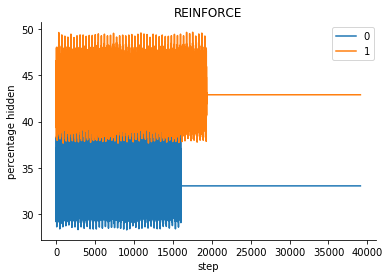

In [24]:
experiment_dir = '../logs/cifar10/hns/stochastic/reinforce/full_training_10/'
reinforce_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir, resample_one_every=None)
reinforce_batch_logs_f = filter_logs_on_val_acc(reinforce_epoch_logs, reinforce_batch_logs, baseline)
plot_all_logs(reinforce_batch_logs_f, 'percentage hidden')
plt.title('REINFORCE')

These estimators don't appear to have the ability of changing the amount of pixels they hide during training, even with the adaptive weighting. This is unexpected as the REINFORCE estimator is the most theoretically sound estimator.

## 3. Comparison

Firstly, let's compare just the accuracy of slope-annealing models, while excluding the latter two because they have no valid solutions regarding their masking capability.

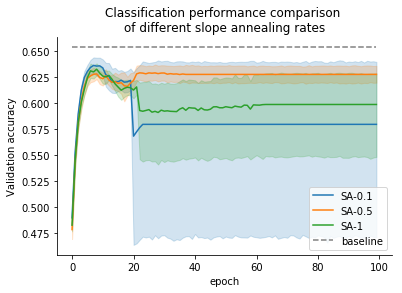

In [25]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_01_epoch_logs), label='SA-0.1')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_1_epoch_logs), label='SA-1')
#sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_10_epoch_logs), label='SA-10')
#sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_100_epoch_logs), label='SA-100')

plt.plot(sa_01_epoch_logs[0]['step'], [baseline] * len(sa_01_epoch_logs[0]),label='baseline', c='0.5', ls='--')

plt.legend(loc='lower right')
plt.xlabel('epoch')
#plt.ylim([0, 0.7])

plt.title('Classification performance comparison \nof different slope annealing rates')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/sa_comparison_classification.pdf', bbox_inches='tight', transparent=True)

The best rate seems to be that with a rate of $0.5$. Let's compare the four estimators now (using the optimal rate for the SA estimator). Also for the same reason as before, we'll exclude the REINFORCE estimator.

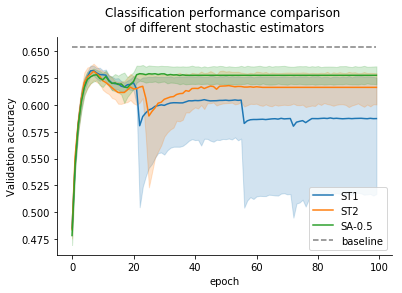

In [26]:
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(st1_epoch_logs), label='ST1')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(st2_epoch_logs), label='ST2')
sns.lineplot(x='step', y='Validation accuracy', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')

plt.plot(st1_epoch_logs[0]['step'], [baseline] * len(st1_epoch_logs[0]), 
         label='baseline', c='0.5', ls='--')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Classification performance comparison \nof different stochastic estimators')
#plt.ylim([0, 0.7])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/stochastic_comparison_classification.pdf', bbox_inches='tight', transparent=True)

The three estimators seem to have similar performances. ST2 and SA seem more stable.

To measure this we'll set a threshold of $90\%$ pixels hidden to filter out sub-optimal solutions. Then we'll see how  many models of each category managed to surpass these two thresholds (i.e. the validation accuracy one and the pixels hidden one).

In [27]:
st1_batch_logs_ff = filter_logs_on_pix_hidden(st1_batch_logs_f)
st2_batch_logs_ff = filter_logs_on_pix_hidden(st2_batch_logs_f)
sa_01_batch_logs_ff = filter_logs_on_pix_hidden(sa_01_batch_logs_f)
sa_05_batch_logs_ff = filter_logs_on_pix_hidden(sa_05_batch_logs_f)
sa_1_batch_logs_ff = filter_logs_on_pix_hidden(sa_1_batch_logs_f)
sa_10_batch_logs_ff = filter_logs_on_pix_hidden(sa_10_batch_logs_f)
sa_100_batch_logs_ff = filter_logs_on_pix_hidden(sa_100_batch_logs_f)
reinforce_batch_logs_ff = filter_logs_on_pix_hidden(reinforce_batch_logs_f)

print('ST1:       ', len(st1_batch_logs_ff))
print('ST2:       ', len(st2_batch_logs_ff))
print('SA-0.1:    ', len(sa_01_batch_logs_ff))
print('SA-0.5:    ', len(sa_05_batch_logs_ff))
print('SA-1:      ', len(sa_1_batch_logs_ff))
print('SA-10:     ', len(sa_10_batch_logs_ff))
print('SA-100:    ', len(sa_100_batch_logs_ff))
print('REINFORCE: ', len(reinforce_batch_logs_ff))

ST1:        4
ST2:        1
SA-0.1:     0
SA-0.5:     2
SA-1:       2
SA-10:      1
SA-100:     0
REINFORCE:  0


Interestingly, even though the models are more stable, only ST1 managed to provide more than $2$ valid solutions, which is also what the deterministic thresholding managed to score. We'll compare the two in another notebook.

Let's compare the three best families. The best model of each family is identified empirically using `plot_all_logs(xxx_batch_logs, 'percentage hidden')`.

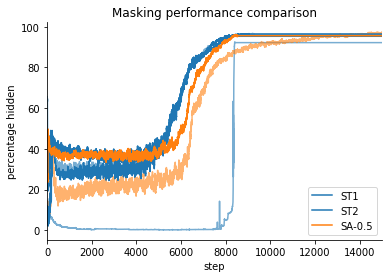

In [28]:
fancy_plot(st1_batch_logs_ff, 'percentage hidden', 2, color='C0', label='ST1')
fancy_plot(st2_batch_logs_ff, 'percentage hidden', 0, color='C0', label='ST2')
fancy_plot(sa_05_batch_logs_ff, 'percentage hidden', 0, color='C1', label='SA-0.5')
plt.xlim([0, 15000])
plt.legend(loc='lower right')
plt.title('Masking performance comparison')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

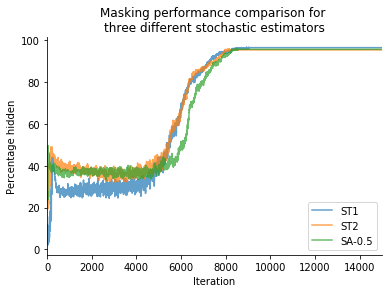

In [29]:
plt.plot(st1_batch_logs_ff[2]['step'], st1_batch_logs_ff[2]['percentage hidden'], color='C0', label='ST1', alpha=0.7)
plt.plot(st2_batch_logs_ff[0]['step'], st2_batch_logs_ff[0]['percentage hidden'], color='C1', label='ST2', alpha=0.7)
plt.plot(sa_05_batch_logs_ff[0]['step'], sa_05_batch_logs_ff[0]['percentage hidden'], color='C2', label='SA-0.5', alpha=0.7)

plt.xlim([0, 15000])
plt.legend(loc='lower right')
plt.title('Masking performance comparison for \nthree different stochastic estimators')
plt.xlabel('Iteration')
plt.ylabel('Percentage hidden')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/stochastic_comparison_masking.pdf', bbox_inches='tight', transparent=True)

All three models seem to converge at a similar pace.

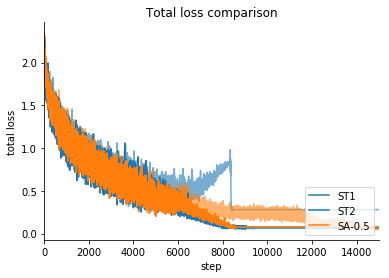

In [30]:
fancy_plot(st1_batch_logs_ff, 'total loss', 2, color='C0', label='ST1')
fancy_plot(st2_batch_logs_ff, 'total loss', 0, color='C0', label='ST2')
fancy_plot(sa_05_batch_logs_ff, 'total loss', 0, color='C1', label='SA-0.5')

plt.xlim([0, 15000])
plt.legend(loc='lower right')
plt.title('Total loss comparison')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

As we say previously, the slope-annealing models reduce their loss at a higher rate than the straight-through one.

Finally, we'll see the **alpha** parameter, whose reduction is an indication of training time.

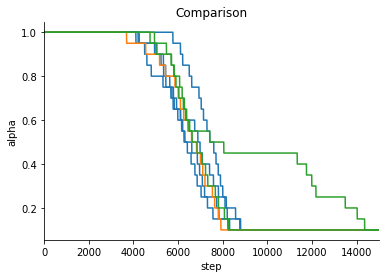

In [31]:
log_type = [st1_batch_logs_ff, st2_batch_logs_ff, sa_05_batch_logs_ff]

for i, logs in enumerate(log_type):
    for log in logs:
        plt.plot(log['step'], log['loss regulator'], c='C'+str(i))
        
plt.xlim([0, 15000])
plt.title('Comparison')
plt.ylabel('alpha')
plt.xlabel('step')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

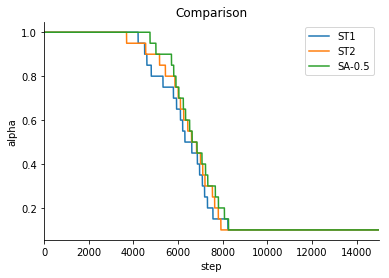

In [32]:
plt.plot(st1_batch_logs_ff[2]['step'], st1_batch_logs_ff[2]['loss regulator'], label='ST1')
plt.plot(st2_batch_logs_ff[0]['step'], st2_batch_logs_ff[0]['loss regulator'], label='ST2')
plt.plot(sa_05_batch_logs_ff[0]['step'], sa_05_batch_logs_ff[0]['loss regulator'], label='SA-0.5')

plt.xlim([0, 15000])
plt.title('Comparison')
plt.ylabel('alpha')
plt.xlabel('step')
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

These two plots confirm the previous statement. However all of these models trained relatively quickly.

### 2D performance projection

Here, we'll compare the models qualitatively on a 2D field based on both their classification and their masking performance.

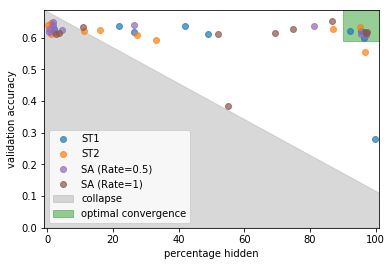

In [33]:
performance_projection_multiple([st1_batch_logs, st2_batch_logs, sa_05_batch_logs, sa_1_batch_logs],
                                [st1_epoch_logs, st2_epoch_logs, sa_05_epoch_logs, sa_1_epoch_logs],
                                baseline=baseline,
                                labels=['ST1', 'ST2', 'SA (Rate=0.5)', 'SA (Rate=1)'],
                                colors=['C0', 'C1', 'C4', 'C5'])

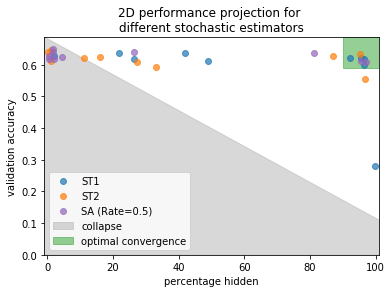

In [34]:
performance_projection_multiple([st1_batch_logs, st2_batch_logs, sa_05_batch_logs],
                                [st1_epoch_logs, st2_epoch_logs, sa_05_epoch_logs],
                                baseline=baseline,
                                labels=['ST1', 'ST2', 'SA (Rate=0.5)'],
                                colors=['C0', 'C1', 'C4'])

plt.title('2D performance projection for \ndifferent stochastic estimators')

plt.savefig('figures/stochastic_comparison_2d.pdf', bbox_inches='tight', transparent=True)

## 3. Fidelity-Interpretability Analysis

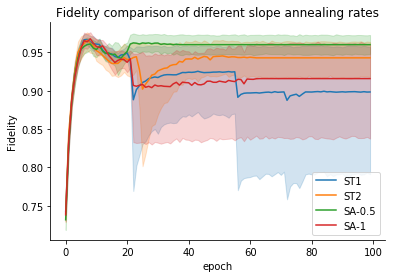

In [35]:
sns.lineplot(x='step', y='Fidelity', data=pd.concat(st1_epoch_logs), label='ST1')
sns.lineplot(x='step', y='Fidelity', data=pd.concat(st2_epoch_logs), label='ST2')
sns.lineplot(x='step', y='Fidelity', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')
sns.lineplot(x='step', y='Fidelity', data=pd.concat(sa_1_epoch_logs), label='SA-1')

plt.legend(loc='lower right')
plt.xlabel('epoch')

plt.title('Fidelity comparison of different slope annealing rates')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

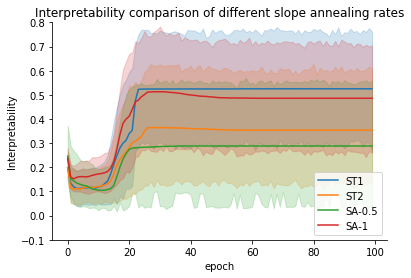

In [36]:
sns.lineplot(x='step', y='Interpretability', data=pd.concat(st1_epoch_logs), label='ST1')
sns.lineplot(x='step', y='Interpretability', data=pd.concat(st2_epoch_logs), label='ST2')
sns.lineplot(x='step', y='Interpretability', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')
sns.lineplot(x='step', y='Interpretability', data=pd.concat(sa_1_epoch_logs), label='SA-1')

plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylim([-0.1, 0.8])

plt.title('Interpretability comparison of different slope annealing rates')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


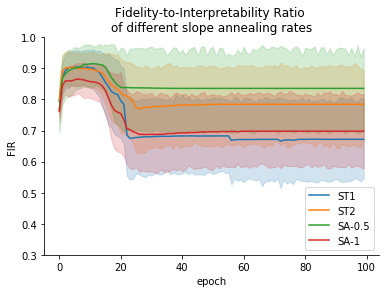

In [37]:
sns.lineplot(x='step', y='FIR', data=pd.concat(st1_epoch_logs), label='ST1')
sns.lineplot(x='step', y='FIR', data=pd.concat(st2_epoch_logs), label='ST2')
sns.lineplot(x='step', y='FIR', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')
sns.lineplot(x='step', y='FIR', data=pd.concat(sa_1_epoch_logs), label='SA-1')

plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylim([0.3, 1])

plt.title('Fidelity-to-Interpretability Ratio \nof different slope annealing rates')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


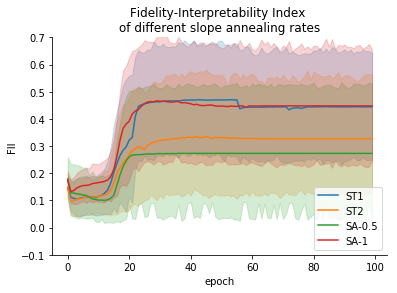

In [38]:
sns.lineplot(x='step', y='FII', data=pd.concat(st1_epoch_logs), label='ST1')
sns.lineplot(x='step', y='FII', data=pd.concat(st2_epoch_logs), label='ST2')
sns.lineplot(x='step', y='FII', data=pd.concat(sa_05_epoch_logs), label='SA-0.5')
sns.lineplot(x='step', y='FII', data=pd.concat(sa_1_epoch_logs), label='SA-1')

plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylim([-0.1, 0.7])

plt.title('Fidelity-Interpretability Index \nof different slope annealing rates')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

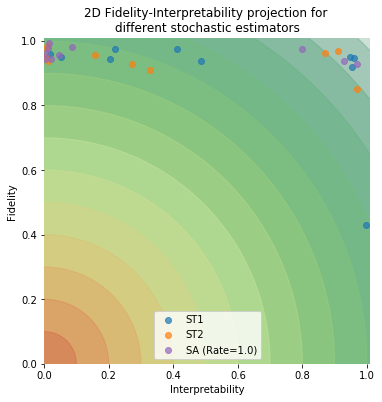

In [41]:
plt.figure(figsize=(6, 6))

fidelity_interpretability_projection([st1_epoch_logs, st2_epoch_logs, sa_05_epoch_logs],
     baseline=0.7,
     labels=['ST1', 'ST2', 'SA (Rate=1.0)'],
     colors=['C0', 'C1', 'C4'],
     max_fii=False)

plt.title('2D Fidelity-Interpretability projection for \ndifferent stochastic estimators')

plt.savefig('figures/stochastic_comparison_fi_2d.pdf', bbox_inches='tight', transparent=True)

From this analysis we can tell that the two best estimators are ST1 and SA (rate=1.0).

## 4. Discussion

### Observations

- The REINFORCE estimator is incapable of working for the specific task.
- The Slope-Annealing estimator works properly for small values of alpha.
- The ST1 and ST2 estimators also appear to work.
- ST2 performes better on classification but can get stuck often in sub-optimal solutions regarding the maksing.
- ST1 seems very robust.
- The best estimators are the SA ones with small slope increase rates (i.e. 0.1 - 1).

### Conclusions

- If classification perfomance is more imoprtant than image masking, then any of the ST estimators is recommended.
- If the masking performance is more important, a SA estimator with a small rate is recommended. 